<a href="https://colab.research.google.com/github/Rish-23072005/AutoRL-Zyara/blob/main/Simluation_routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install osmnx
!pip install folium
!pip install plotly
!pip install ortools

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [10]:
city = "London"
dtf=pd.read_csv('data_stores.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

total 216


,id,City,Street Address,y,x
0,0,London,265 Wharncliffe Rd North,42.99,-81.26
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22
2,2,London,631 Commissioners Road East,42.96,-81.23


In [11]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)
print("starting point:" , start)

starting point: [ 42.99 -81.26]


In [12]:
map = folium.Map(location=start, tiles= "cartodbpositron", zoom_start=12)
data.apply(lambda row:
    folium.CircleMarker(
        location=[row["y"], row["x"]],
        color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map

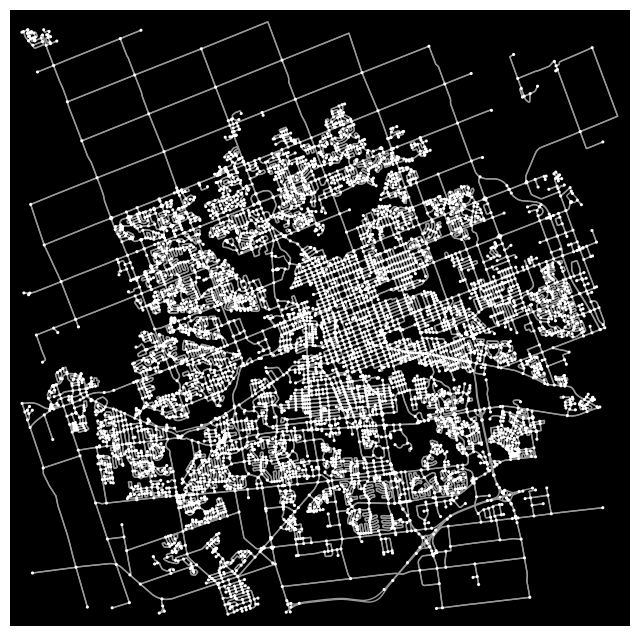

In [13]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="white", figsize=(16,8))

In [14]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

<ipython-input-14-3f563add5754>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
<ipython-input-14-3f563add5754>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
<ipython-input-14-3f563add5754>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["

,id,City,Street Address,y,x,node
0,0,London,265 Wharncliffe Rd North,42.99,-81.26,289796441
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22,324811692
2,2,London,631 Commissioners Road East,42.96,-81.23,11756886360
3,3,London,1442 Fanshawe Park Road,43.01,-81.34,252974916
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26,302754873


In [15]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0.0,563.6,353.7,594.8,498.6,403.2,127.1,393.7,554.8,101.6,514.3,435.2,233.2,199.4,567.4,227.4,524.3,477.2,1036.3,1047.5
324811692,589.8,0.0,210.9,1099.8,951.8,713.2,458.3,871.3,736.5,489.8,402.4,890.7,670.0,403.5,681.3,780.0,119.8,982.2,1313.1,783.5
11756886360,378.9,209.9,0.0,913.5,740.9,579.9,247.4,660.4,550.2,278.9,413.8,704.4,459.1,192.6,585.5,581.1,240.0,795.9,1205.1,916.2
252974916,593.0,1096.7,915.2,0.0,429.0,858.2,704.6,324.1,481.6,665.5,726.0,356.4,500.8,764.1,1084.3,433.3,1026.2,174.9,1309.9,981.0
302754873,498.5,952.6,742.7,430.0,0.0,480.4,572.9,107.3,892.0,513.2,865.1,764.7,348.5,569.3,706.5,395.1,982.3,312.4,932.1,1391.4


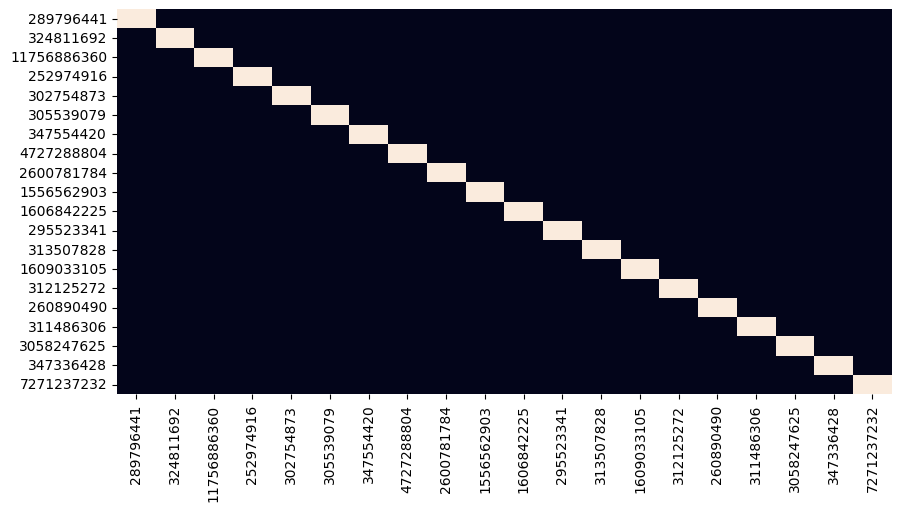

In [16]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x:
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else
          (0 if x!=0 else 1)) )

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()

In [17]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0,564,354,595,499,403,127,394,555,102,514,435,233,199,567,227,524,477,1036,1048
324811692,590,0,211,1100,952,713,458,871,737,490,402,891,670,403,681,780,120,982,1313,783
11756886360,379,210,0,914,741,580,247,660,550,279,414,704,459,193,586,581,240,796,1205,916
252974916,593,1097,915,0,429,858,705,324,482,666,726,356,501,764,1084,433,1026,175,1310,981
302754873,498,953,743,430,0,480,573,107,892,513,865,765,348,569,706,395,982,312,932,1391
305539079,403,645,584,861,484,0,435,538,894,376,867,767,412,410,309,559,748,744,689,1363
347554420,149,456,246,716,572,435,0,467,520,92,479,518,265,92,491,351,428,598,1068,1013
4727288804,391,869,659,323,107,536,466,0,785,406,758,657,241,505,763,288,875,205,988,1284
2600781784,555,732,550,478,887,890,520,782,0,603,361,186,720,577,1002,564,661,633,1523,634
1556562903,169,488,278,668,512,376,92,407,603,0,562,538,206,124,492,337,502,550,1009,1095


In [18]:
drivers = 1
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 289796441 total locations to visit 19 drivers 1


In [19]:
manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [20]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [21]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))

    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

route for driver:
[0, 6, 9, 13, 2, 1, 16, 10, 8, 11, 3, 17, 7, 4, 12, 15, 5, 14, 18, 19]
Total distance:6.7km
Nodes visited: 20


In [22]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 347554420, 1556562903, 1609033105, 11756886360, 324811692, 311486306, 1606842225, 2600781784, 295523341, 252974916, 3058247625, 4727288804, 302754873, 313507828, 260890490, 305539079, 312125272, 347336428, 7271237232]


In [23]:
!pip install osmnx

In [24]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)

map

In [25]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], []

        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])

        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)),
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))

    df=df.reset_index().rename(columns={"index":"id"})
    return df

In [27]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [28]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig